# Predicting House Sale Prices
## working with housing data for the City of Ames, Iowa to predict housse sale prices

import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import KFold
pd.options.display.max_columns = 100
%matplotlib inline

In [2]:
data=pd.read_csv('AmesHousing.tsv', delimiter='\t')

## data exploration

In [3]:
print(data.head(5))

   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour Utilities Lot Config Land Slope Neighborhood  \
0   NaN       IR1          Lvl    AllPub     Corner        Gtl        NAmes   
1   NaN       Reg          Lvl    AllPub     Inside        Gtl        NAmes   
2   NaN       IR1          Lvl    AllPub     Corner        Gtl        NAmes   
3   NaN       Reg          Lvl    AllPub     Corner        Gtl        NAmes   
4   NaN       IR1          Lvl    AllPub     Inside        Gtl      Gilbert   

  Condition 1 Condition 2 Bldg Type House Style  Overall Qual 

## building first iteration of model

In [4]:
def transform_features(input_df):
    return input_df
def select_features(input_df):
    return input_df[['Gr Liv Area', 'SalePrice']]
def train_and_test(input_df):
    train=input_df.iloc[:1460]
    test=input_df.iloc[1460:]
    num_features=input_df.select_dtypes(include=['integer', 'float']).columns.drop('SalePrice')
    lr=linear_model.LinearRegression()
    lr.fit(train[num_features], train['SalePrice'])
    predictions=lr.predict(test[num_features])
    rmse=math.sqrt(mean_squared_error(predictions, test['SalePrice']))
    return rmse

In [5]:
clean_data=transform_features(data)
selected_features_df=select_features(clean_data)
rmse=train_and_test(selected_features_df)
print(rmse)

57088.25161263909


this is the benchmark rmse by including only the 'Gr Liv Area' feature

## cleaning data

handling missing values:
-  numerical cols: remove cols with 5%+ missing values and fill the rest of the missing values with the most common values in the column
-  text cols: remove cols with missing values

In [6]:
def transform_features(input_df):
    threshold=len(input_df)*0.05
    all_missing_values=input_df.isnull().sum()
    input_df=input_df.drop(all_missing_values[all_missing_values>threshold].index, axis=1)
    text_missing_values=input_df.select_dtypes(include=['object']).isnull().sum()
    input_df=input_df.drop(text_missing_values[text_missing_values>0].index, axis=1)
    num_missing_values=input_df.select_dtypes(include=['integer', 'float']).isnull().sum()
    num_missing_cols=num_missing_values[num_missing_values>0].index
    for each_col in num_missing_cols:
        input_df[each_col]=input_df[each_col].fillna(input_df[each_col].mode()[0])
    return input_df

In [7]:
clean_data=transform_features(data)
selected_features_df=select_features(clean_data)
# rmse=train_and_test(selected_features_df)
rmse=train_and_test(clean_data)
print(rmse)

72651.79286397778


rmse seems to have increased significantly by including all features

## more cleaning data

further feature engineering:
-  make text and appropriate numerical cols categorical
-  add new columns

In [8]:
def transform_features(input_df):
    threshold=len(input_df)*0.05
    all_missing_values=input_df.isnull().sum()
    input_df=input_df.drop(all_missing_values[all_missing_values>threshold].index, axis=1)
    text_missing_values=input_df.select_dtypes(include=['object']).isnull().sum()
    input_df=input_df.drop(text_missing_values[text_missing_values>0].index, axis=1)
    # new columns and drop old columns
    input_df['years_to_sell']=input_df['Yr Sold']-input_df['Year Built']
    input_df['years_since_remodel'] = input_df['Yr Sold']-input_df['Year Remod/Add']
    input_df=input_df.drop(input_df[((input_df['years_to_sell']<0) | (input_df['years_since_remodel']<0))].index, axis=0)
    input_df=input_df.drop(['Year Remod/Add', 'Year Built'], axis=1)
    # manually remove columns
    dropped_cols=['PID', 'Order']
    input_df=input_df.drop(dropped_cols, axis=1)
    # manually remove columns that contain data leakage
    leaked_cols=['Sale Condition', 'Sale Type']
    input_df=input_df.drop(leaked_cols, axis=1)
    num_missing_values=input_df.select_dtypes(include=['integer', 'float']).isnull().sum()
    num_missing_cols=num_missing_values[num_missing_values>0].index
    for each_col in num_missing_cols:
        input_df[each_col]=input_df[each_col].fillna(input_df[each_col].mode()[0])
    return input_df

In [9]:
clean_data=transform_features(data)
selected_features_df=select_features(clean_data)
# check number of null values
# print(clean_data.isnull().sum().value_counts(dropna=False))
rmse=train_and_test(clean_data)
# rmse=train_and_test(selected_features_df)
print(rmse)

70850.03601228134


## generate correlation heatmap matrix

testing to see what's the best correlation cut off to use

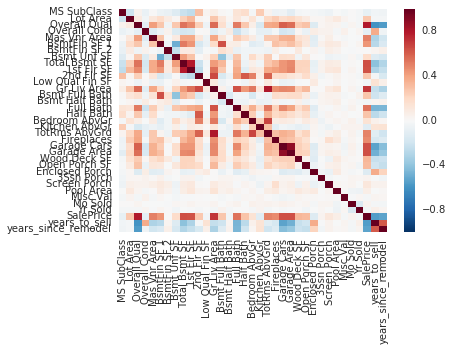

In [10]:
clean_data=transform_features(data)
numerical_df=clean_data.select_dtypes(include=['int', 'float'])
corr_coeffs=numerical_df.corr()['SalePrice'].abs().sort_values(ascending=False)
sns.heatmap(numerical_df.corr())
plt.show()

includes below features:

SalePrice              1.000000
Overall Qual           0.801206
Gr Liv Area            0.717596
Garage Cars            0.648361
Total Bsmt SF          0.644012
Garage Area            0.641425
1st Flr SF             0.635185
years_to_sell          0.558979
Full Bath              0.546118
years_since_remodel    0.534985
Mas Vnr Area           0.506983
TotRms AbvGrd          0.498574
Fireplaces             0.474831
BsmtFin SF 1           0.439284
Wood Deck SF           0.328183
Open Porch SF          0.316262
Half Bath              0.284871
Bsmt Full Bath         0.276258
2nd Flr SF             0.269601
Lot Area               0.267520
Bsmt Unf SF            0.182751
Bedroom AbvGr          0.143916
Enclosed Porch         0.128685
Kitchen AbvGr          0.119760
Screen Porch           0.112280
Overall Cond           0.101540
MS SubClass            0.085128
Pool Area              0.068438
Low Qual Fin SF        0.037629
Bsmt Half Bath         0.035875
Mo Sold       

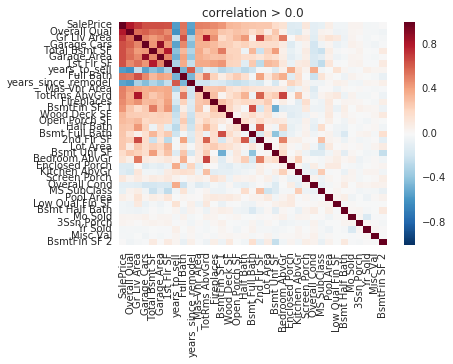

70850.03601228134
includes below features:

SalePrice              1.000000
Overall Qual           0.801206
Gr Liv Area            0.717596
Garage Cars            0.648361
Total Bsmt SF          0.644012
Garage Area            0.641425
1st Flr SF             0.635185
years_to_sell          0.558979
Full Bath              0.546118
years_since_remodel    0.534985
Mas Vnr Area           0.506983
TotRms AbvGrd          0.498574
Fireplaces             0.474831
BsmtFin SF 1           0.439284
Wood Deck SF           0.328183
Open Porch SF          0.316262
Half Bath              0.284871
Bsmt Full Bath         0.276258
2nd Flr SF             0.269601
Lot Area               0.267520
Bsmt Unf SF            0.182751
Bedroom AbvGr          0.143916
Enclosed Porch         0.128685
Kitchen AbvGr          0.119760
Screen Porch           0.112280
Overall Cond           0.101540
Name: SalePrice, dtype: float64


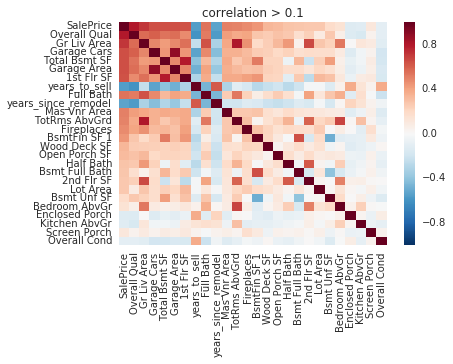

35569.52579823283
includes below features:

SalePrice              1.000000
Overall Qual           0.801206
Gr Liv Area            0.717596
Garage Cars            0.648361
Total Bsmt SF          0.644012
Garage Area            0.641425
1st Flr SF             0.635185
years_to_sell          0.558979
Full Bath              0.546118
years_since_remodel    0.534985
Mas Vnr Area           0.506983
TotRms AbvGrd          0.498574
Fireplaces             0.474831
BsmtFin SF 1           0.439284
Wood Deck SF           0.328183
Open Porch SF          0.316262
Half Bath              0.284871
Bsmt Full Bath         0.276258
2nd Flr SF             0.269601
Lot Area               0.267520
Name: SalePrice, dtype: float64


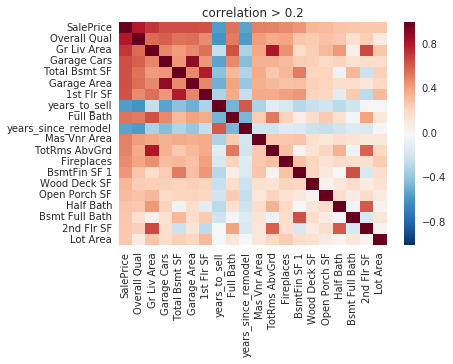

36689.486570353125
includes below features:

SalePrice              1.000000
Overall Qual           0.801206
Gr Liv Area            0.717596
Garage Cars            0.648361
Total Bsmt SF          0.644012
Garage Area            0.641425
1st Flr SF             0.635185
years_to_sell          0.558979
Full Bath              0.546118
years_since_remodel    0.534985
Mas Vnr Area           0.506983
TotRms AbvGrd          0.498574
Fireplaces             0.474831
BsmtFin SF 1           0.439284
Wood Deck SF           0.328183
Open Porch SF          0.316262
Name: SalePrice, dtype: float64


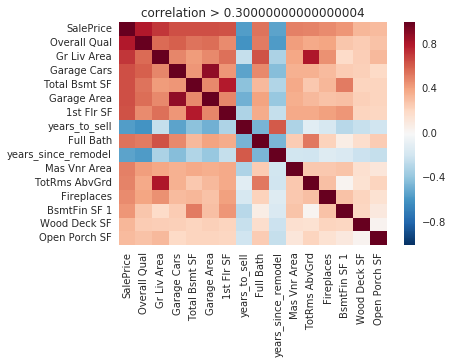

36607.88007627672
includes below features:

SalePrice              1.000000
Overall Qual           0.801206
Gr Liv Area            0.717596
Garage Cars            0.648361
Total Bsmt SF          0.644012
Garage Area            0.641425
1st Flr SF             0.635185
years_to_sell          0.558979
Full Bath              0.546118
years_since_remodel    0.534985
Mas Vnr Area           0.506983
TotRms AbvGrd          0.498574
Fireplaces             0.474831
BsmtFin SF 1           0.439284
Name: SalePrice, dtype: float64


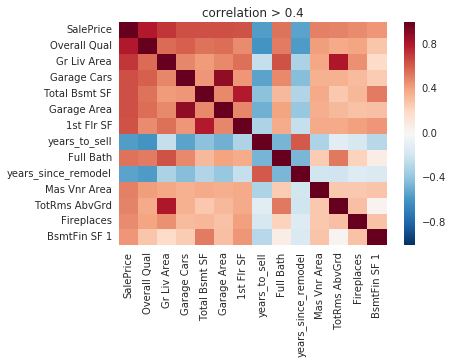

36623.53562910476
includes below features:

SalePrice              1.000000
Overall Qual           0.801206
Gr Liv Area            0.717596
Garage Cars            0.648361
Total Bsmt SF          0.644012
Garage Area            0.641425
1st Flr SF             0.635185
years_to_sell          0.558979
Full Bath              0.546118
years_since_remodel    0.534985
Mas Vnr Area           0.506983
Name: SalePrice, dtype: float64


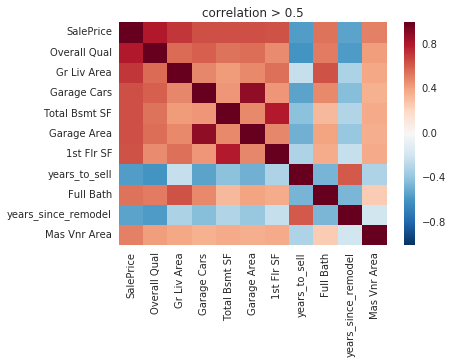

36957.16119425585
includes below features:

SalePrice        1.000000
Overall Qual     0.801206
Gr Liv Area      0.717596
Garage Cars      0.648361
Total Bsmt SF    0.644012
Garage Area      0.641425
1st Flr SF       0.635185
Name: SalePrice, dtype: float64


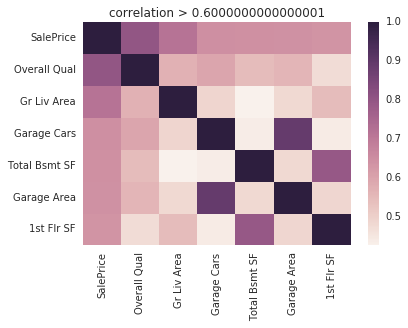

38360.024509138195
includes below features:

SalePrice       1.000000
Overall Qual    0.801206
Gr Liv Area     0.717596
Name: SalePrice, dtype: float64


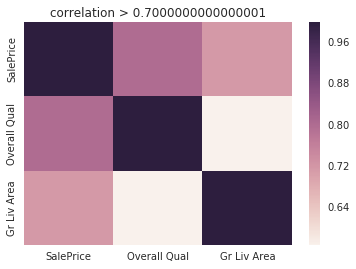

40697.38880707488
includes below features:

SalePrice       1.000000
Overall Qual    0.801206
Name: SalePrice, dtype: float64


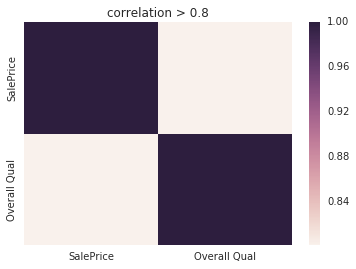

49145.59900957989


In [11]:
for i in np.arange(0, 0.9, 0.1):
    corr_features=corr_coeffs[corr_coeffs>i].index
    clean_data=clean_data.drop(corr_coeffs[corr_coeffs<i].index, axis=1)
    corr_coeffs=corr_coeffs.drop(corr_coeffs[corr_coeffs<i].index)
    print('includes below features:\n')
    print(corr_coeffs)
    rmse=train_and_test(clean_data)
    sns.heatmap(numerical_df[corr_features].corr())
    plt.title('correlation > {}'.format(i))
    plt.show()
    print(rmse)

## enable categorical features

looking at documentation to identify categorical features

check number of unique values in text columns

In [12]:
clean_data=transform_features(data)
text_data=clean_data.select_dtypes(include='object').columns
for each_col in text_data:
    print(clean_data[each_col].value_counts(dropna=False))

RL         2270
RM          462
FV          139
RH           27
C (all)      25
A (agr)       2
I (all)       2
Name: MS Zoning, dtype: int64
Pave    2915
Grvl      12
Name: Street, dtype: int64
Reg    1859
IR1     976
IR2      76
IR3      16
Name: Lot Shape, dtype: int64
Lvl    2632
HLS     120
Bnk     115
Low      60
Name: Land Contour, dtype: int64
AllPub    2924
NoSewr       2
NoSeWa       1
Name: Utilities, dtype: int64
Inside     2138
Corner      510
CulDSac     180
FR2          85
FR3          14
Name: Lot Config, dtype: int64
Gtl    2786
Mod     125
Sev      16
Name: Land Slope, dtype: int64
NAmes      443
CollgCr    267
OldTown    239
Edwards    192
Somerst    182
NridgHt    165
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
Grn

In [19]:
def select_features(input_df, corr_coeff_threshold):
    num_cat_cols=['MS SubClass']
    text_cols=input_df.select_dtypes(include=['object']).columns.tolist()
    all_cat_cols=text_cols+num_cat_cols
    # enable categorical features
    for each_col in all_cat_cols:
        input_df[each_col]=input_df[each_col].astype('category')
        input_df=pd.concat([input_df, pd.get_dummies(input_df[each_col], prefix=each_col)], axis=1)
        input_df=input_df.drop(each_col, axis=1)
    numerical_df=input_df.select_dtypes(include=['int', 'float'])
    corr_coeffs=numerical_df.corr()['SalePrice'].abs().sort_values(ascending=False)
    input_df=input_df.drop(corr_coeffs[corr_coeffs<corr_coeff_threshold].index, axis=1)
    return input_df

In [25]:
clean_data=transform_features(data)
selected_features_df=select_features(clean_data, 0.4)
# for each_feature in selected_features_df:
#     print(each_feature)
rmse=train_and_test(selected_features_df)
# rmse=train_and_test(clean_data)
print(rmse)

31904.254033193345


## add k parameter to control the type of cross validation that occurs (K Fold)

In [45]:
def train_and_test(input_df, k=0):
    num_features=input_df.select_dtypes(include=['integer', 'float']).columns.drop('SalePrice')
    lr=linear_model.LinearRegression()
    if k==0:
        train=input_df.iloc[:1460]
        test=input_df.iloc[1460:]
        lr.fit(train[num_features], train['SalePrice'])
        predictions=lr.predict(test[num_features])
        rmse=math.sqrt(mean_squared_error(predictions, test['SalePrice']))
    elif k==1:
        rmses=[]
        shuffled_index=np.random.permutation(input_df.index)
        input_df=input_df.reindex(shuffled_index)
        fold_one=input_df.iloc[:1460]
        fold_two=input_df.iloc[1460:]
        lr.fit(fold_one[num_features], fold_one['SalePrice'])
        predictions=lr.predict(fold_two[num_features])
        rmses.append(math.sqrt(mean_squared_error(predictions, fold_two['SalePrice'])))
        lr.fit(fold_two[num_features], fold_two['SalePrice'])
        predictions=lr.predict(fold_one[num_features])
        rmses.append(math.sqrt(mean_squared_error(predictions, fold_one['SalePrice'])))
        rmse=np.mean(rmses)
    else:
        rmse=[]
        kf=KFold(n_splits=k, shuffle=True)
        for train_index, test_index, in kf.split(input_df):
            train=input_df.iloc[train_index]
            test=input_df.iloc[test_index]
            lr.fit(train[num_features], train['SalePrice'])
            predictions=lr.predict(test[num_features])
            rmses.append(math.sqrt(mean_squared_error(test['SalePrice'], predictions)))
        print(rmses)
        rmse=np.mean(rmses)
    return rmse

In [46]:
clean_data=transform_features(data)
selected_features_df=select_features(clean_data, 0.4)
# for each_feature in selected_features_df:
#     print(each_feature)
rmse=train_and_test(selected_features_df)
# rmse=train_and_test(clean_data)
print(rmse)
rmse=train_and_test(selected_features_df, 1)
# rmse=train_and_test(clean_data)
print(rmse)
rmse=train_and_test(selected_features_df, 4)
# rmse=train_and_test(clean_data)
print(rmse)

31904.254033193345
28942.79749993748


NameError: name 'features' is not defined

In [17]:
def transform_features(df):
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df

def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1)
    
    return df

def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    else:
        kf=KFold(n_splits=k, shuffle=True)
        rmse_values=[]
        for train_index, test_index in kf.split(input_df):
            train=input_df.iloc[train_index]
            test=input_df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=4)
rmse
for each_col in filtered_df.columns:
    print(each_col)

[25179.012442695748, 38171.72506719154, 23346.789915179732, 27437.892307144943]
MS Zoning
Street
Lot Shape
Land Contour
Utilities
Lot Config
Land Slope
Condition 1
Condition 2
Bldg Type
House Style
Overall Qual
Roof Style
Roof Matl
Mas Vnr Area
Exter Qual
Exter Cond
Foundation
BsmtFin SF 1
Total Bsmt SF
Heating
Heating QC
Central Air
1st Flr SF
Gr Liv Area
Full Bath
Kitchen Qual
TotRms AbvGrd
Functional
Fireplaces
Garage Cars
Garage Area
Paved Drive
SalePrice
Years Before Sale
Years Since Remod
MS Zoning_A (agr)
MS Zoning_C (all)
MS Zoning_FV
MS Zoning_I (all)
MS Zoning_RH
MS Zoning_RL
MS Zoning_RM
Street_Grvl
Street_Pave
Lot Shape_IR1
Lot Shape_IR2
Lot Shape_IR3
Lot Shape_Reg
Land Contour_Bnk
Land Contour_HLS
Land Contour_Low
Land Contour_Lvl
Utilities_AllPub
Utilities_NoSeWa
Utilities_NoSewr
Lot Config_Corner
Lot Config_CulDSac
Lot Config_FR2
Lot Config_FR3
Lot Config_Inside
Land Slope_Gtl
Land Slope_Mod
Land Slope_Sev
Condition 1_Artery
Condition 1_Feedr
Condition 1_Norm
Condition 1

In [18]:
def transform_features(df):
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df

def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):  
    train = df[:1460]
    test = df[1460:]
    
    ## You can use `pd.DataFrame.select_dtypes()` to specify column types
    ## and return only those columns as a data frame.
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    ## You can use `pd.Series.drop()` to drop a value.
    features = numeric_train.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
print(filtered_df.columns)

rmse

Index(['Gr Liv Area', 'SalePrice'], dtype='object')


55275.36731241307